In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [11]:
# torch.cuda.set_device(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

torch.cuda.empty_cache()

device

device(type='cuda')

## General diffusion framework

In [12]:
class Diffusion(torch.nn.Module):
    def __init__(self, denoiser, loss=None, T=5):
        super().__init__()
        
        self.denoiser = denoiser
        self.loss = loss
        self.T = T
        
        if self.loss is None:
            self.loss = torch.nn.MSELoss()

    def apply_noise(self, x: torch.Tensor, z: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        return p * x + torch.sqrt(1.0 - p**2) * z

    def get_denoising_loss(self, x: torch.Tensor) -> torch.Tensor: 
        batch_size = x.shape[0]
        
        t = torch.rand((batch_size,), device=device) * self.T
        p = torch.exp(-t)
        # p = torch.sqrt(1.0 - torch.rand((batch_size,), device=x.device)**2.0)
        
        z = torch.randn(x.shape, device=x.device)

        x_noisy = self.apply_noise(x, z, p)

        z_pred = self.denoiser(x_noisy, p)

        return self.loss(z_pred, z)

    def sample(self, z: torch.Tensor, p_schedule: torch.Tensor) -> torch.Tensor:
        
        # \overline{\alpha}_t = p_t^2
        # \overline{\alpha}_t = \prod_{s=1}^t \alpha_s
        # \alpha_s = 1 - \beta_s
        # \sigma_t^2 = \beta_t \frac{1 - \overline{\alpha}_{t-1}}{1 - \overline{\alpha}_t}

        overline_alpha = p_schedule**2
        alpha = overline_alpha[1::] / overline_alpha[:-1:]
        beta = 1.0 - alpha
        sigma = torch.sqrt(beta * (1.0 - overline_alpha[:-1:]) / (1.0 - overline_alpha[1::]))

        x = z

        for step in range(1, p_schedule.shape[0]):
            z_pred = self.denoiser(x, p_schedule[-step].repeat(x.shape[0]))
            
            x = (x - z_pred * beta[-step] / torch.sqrt(1.0 - overline_alpha[-step])) / torch.sqrt(alpha[-step])
            x += sigma[-step] * torch.randn(x.shape, device=x.device)

        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.get_denoising_loss(x)

### MLP Denoiser

In [13]:
# class MLPDenoiser(torch.nn.Module):
#     def __init__(self, data_dim: int, hidden_dim: int = 1024):
#         super().__init__()

#         self.fc1 = torch.nn.Linear(data_dim + 1, hidden_dim // 8)
#         self.fc2 = torch.nn.Linear(hidden_dim // 8, hidden_dim // 4)
#         self.fc3 = torch.nn.Linear(hidden_dim // 4, hidden_dim // 2)
#         self.fc4 = torch.nn.Linear(hidden_dim // 2, hidden_dim)

#         self.fc5 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
#         self.fc6 = torch.nn.Linear(hidden_dim // 2, hidden_dim // 4)
#         self.fc7 = torch.nn.Linear(hidden_dim // 4, hidden_dim // 8)
#         self.fc8 = torch.nn.Linear(hidden_dim // 8, data_dim)

#         self.act = torch.nn.LeakyReLU()

#         self.skip1 = torch.nn.Linear(data_dim + 1, hidden_dim // 4)
#         self.skip2 = torch.nn.Linear(hidden_dim // 4, hidden_dim // 2)
#         self.skip3 = torch.nn.Linear(hidden_dim // 2, hidden_dim // 2)
#         self.skip4 = torch.nn.Linear(hidden_dim, hidden_dim // 4)
#         self.skip5 = torch.nn.Linear(hidden_dim // 2, hidden_dim // 8)

#     def forward(self, x: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
#         p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
#         x_p = torch.cat([x, p], dim=-1)

#         h1 = self.act(self.fc1(x_p))
#         h2 = self.act(self.fc2(h1) + self.skip1(x_p))
#         h3 = self.act(self.fc3(h2) + self.skip2(h2))
#         h4 = self.act(self.fc4(h3))

#         h5 = self.act(self.fc5(h4) + self.skip3(h3))
#         h6 = self.act(self.fc6(h5) + self.skip4(h4))
#         h7 = self.act(self.fc7(h6) + self.skip5(h5))
#         out = self.fc8(h7)

#         return out

class MLPDenoiser(torch.nn.Module):
    def __init__(self, data_dim: int, hidden_dim: int=300):
        super().__init__()

        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(data_dim + 1, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, data_dim),
        )

    def forward(self, x: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        x_p = torch.cat([x, p], dim=-1)

        return self.MLP(x_p)

In [14]:
def draw_loss(losses):
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Train loss over time")
    plt.show()

In [15]:
def train(
    model,
    optimizer,
    scheduler,
    train_dataloader,
    n_epochs,
    draw_every=1000
):
    step = 0
    losses = []
    
    for epoch in trange(n_epochs):
        for batch in train_dataloader:
            if isinstance(batch, list):
                batch = batch[0]
            
            optimizer.zero_grad()
            
            loss = model(batch.to(device))
            loss.backward()
            
            optimizer.step()
            
            losses.append(loss.item())
            
            if step % draw_every == 0:
                clear_output(wait=True)
                draw_loss(losses)
                tqdm.write(f"Epoch [{epoch+1}/{n_epochs}], Step [{step}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
            
            step += 1
            
        scheduler.step()

### 2D test

In [16]:
n_samples = 1000

with torch.no_grad():
    train_x_tensor = torch.rand((n_samples, 2)) + 4 * (torch.randint(2, size=(n_samples,1)) - 0.5) - 0.5
    test_x_tensor  = torch.zeros((n_samples, 2)) + 4 * (torch.randint(2, size=(n_samples,1)) - 0.5) - 0.5
    
    train_x_tensor /= torch.std(train_x_tensor)
    test_x_tensor  /= torch.std(test_x_tensor)

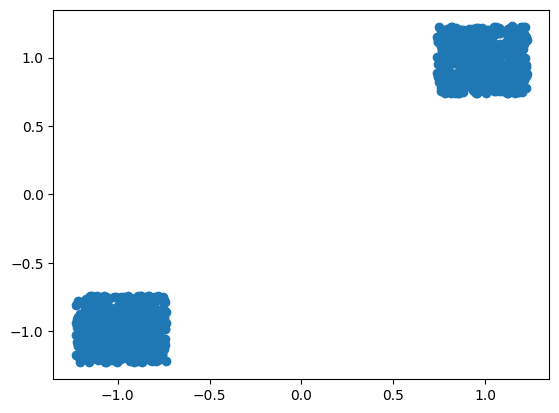

In [17]:
plt.scatter(train_x_tensor[:,0].numpy(), train_x_tensor[:,1].numpy())

In [18]:
train_dataset = TensorDataset(train_x_tensor)
test_dataset = TensorDataset(test_x_tensor)

In [19]:
train_dataloader = DataLoader(train_x_tensor, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_x_tensor, batch_size=512, shuffle=False)

In [20]:
model = Diffusion(
    MLPDenoiser(2)
).to(device)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

In [22]:
# train(model, optimizer, train_dataloader, 1000)

In [23]:
z = torch.randn((500, 2), device=device)
# p_schedule = torch.linspace(1.0, 0.01, 100, device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0)

In [24]:
with torch.no_grad():
    sampled = model.sample(z, p_schedule)

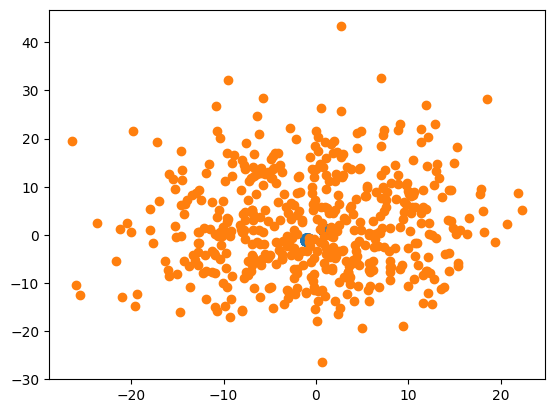

In [25]:
plt.scatter(train_x_tensor[:,0].numpy(), train_x_tensor[:,1].numpy())
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,1].cpu().numpy())

# MI

In [33]:
n_dim = 2
n_samples = 1000000

In [34]:
def create_nd_correlated_data(n_samples, n_dim, r=0.7):
    n_half = n_dim // 2
    mean = torch.zeros(n_dim)
    
    cov = torch.eye(n_dim)
    
    for i in range(n_dim):
        cov[i, n_dim - i - 1] = r

    mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    dep_data = mvn.sample((n_samples,))
    
    A = dep_data[:, :n_half]
    B = dep_data[:, n_half:]
    
    indep_data = torch.cat([A, B[torch.randperm(n_samples)]], dim=1)
    
    return dep_data, indep_data, cov

In [35]:
def random_covariance_matrix(n):
    A = torch.randn(n, n)
    cov = A @ A.T
    d = torch.sqrt(torch.diag(cov))
    cov = cov / (d.unsqueeze(0) * d.unsqueeze(1))
    return cov

def create_randomly_correlated_normal_data(n_samples, n_dim):
    n_half = n_dim // 2
    mean = torch.zeros(n_dim)
    
    cov = random_covariance_matrix(n_dim)

    joint = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    dep_data = joint.sample((n_samples,))
    
    cov_1 = cov[:n_half, :n_half]
    cov_2 = cov[n_half:, n_half:]
    
    marginal_1 = torch.distributions.MultivariateNormal(torch.zeros(n_half), covariance_matrix=cov_1)
    marginal_2 = torch.distributions.MultivariateNormal(torch.zeros(n_half), covariance_matrix=cov_2)
    
    A = marginal_1.sample((n_samples,))
    B = marginal_2.sample((n_samples,))
    
    indep_data = torch.cat([A, B], dim=1)
    
    return dep_data, indep_data, cov    

def MI_multivariate_normal(cov):
    n_dim = cov.shape[1]
    n_half = n_dim // 2
    cov_1 = cov[:n_half, :n_half]
    cov_2 = cov[n_half:, n_half:]
    det_cov_1 = torch.abs(torch.linalg.det(cov_1))
    det_cov_2 = torch.abs(torch.linalg.det(cov_2))
    det_cov = torch.abs(torch.linalg.det(cov))
    return torch.log(det_cov_1 * det_cov_2 / det_cov) / 2

In [36]:
import torch

def create_circle_data(n_samples: int, r: float = 1.0):
    alpha = torch.rand(n_samples) * 2 * torch.pi

    x = r * torch.cos(alpha)
    y = r * torch.sin(alpha)

    dep_data = torch.stack([x, y], dim=1)

    perm = torch.randperm(n_samples)
    indep_data = torch.stack([x, y[perm]], dim=1)

    return dep_data, indep_data, 0


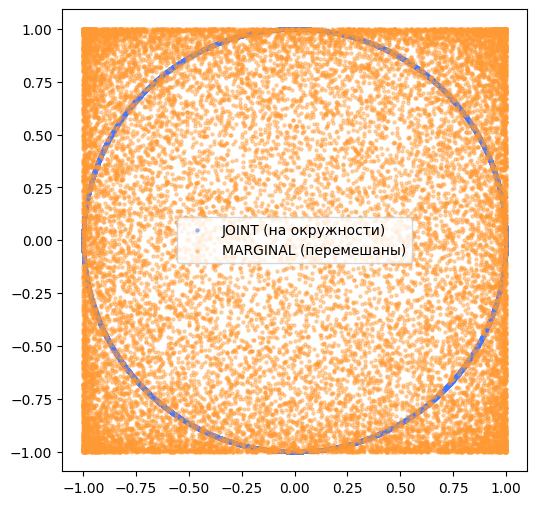

In [37]:
dep_data, indep_data, _ = create_circle_data(20000, r=1.0)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(dep_data[:,0], dep_data[:,1], s=5, color="#4477ff", alpha=0.4, label="JOINT (на окружности)")
plt.scatter(indep_data[:,0], indep_data[:,1], s=5, color="#ff9933", alpha=0.4, label="MARGINAL (перемешаны)")
plt.axis("equal")
plt.legend()
plt.show()



In [38]:
# dep_data, indep_data, cov = create_nd_correlated_data(n_samples, n_dim=n_dim, r=0.9)
dep_data, indep_data, cov = create_circle_data(n_samples)
# dep_data, indep_data, cov = create_randomly_correlated_normal_data(n_samples, n_dim=6)
MI_multivariate_normal(cov)
print(dep_data.shape)

AttributeError: 'int' object has no attribute 'shape'

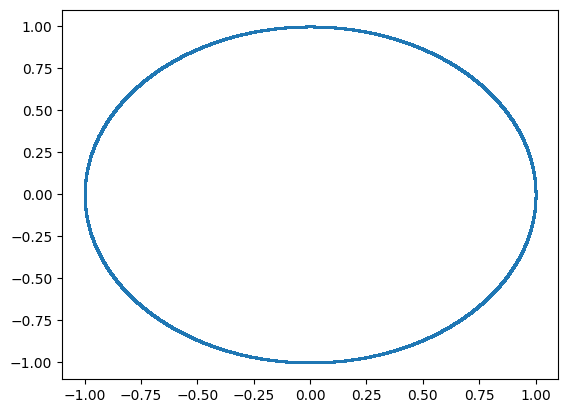

In [39]:
plt.scatter(dep_data[:, 0], dep_data[:, n_dim-1], s=1)

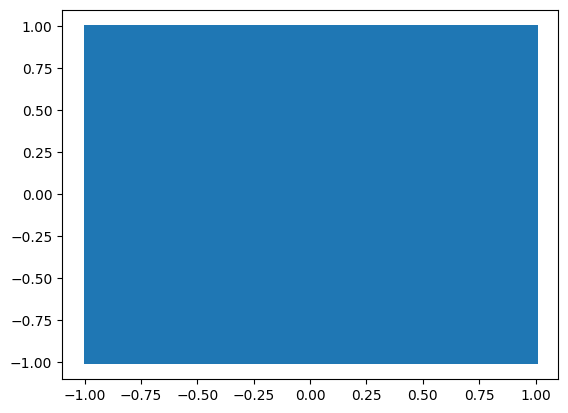

In [40]:
plt.scatter(indep_data[:, 0], indep_data[:, n_dim-1], s=1)

In [41]:
dep_train_dataset = TensorDataset(dep_data)
indep_train_dataset = TensorDataset(indep_data)

dep_train_dataloader = DataLoader(dep_train_dataset, batch_size=256, shuffle=True)
indep_train_dataloader = DataLoader(indep_train_dataset, batch_size=256, shuffle=False)

In [42]:
num_epochs = 100

In [43]:
model_AB = Diffusion(MLPDenoiser(n_dim)).to(device)
model_A_B = Diffusion(MLPDenoiser(n_dim)).to(device)

In [44]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer_AB = torch.optim.Adam(model_AB.parameters(), lr=1e-3)
optimizer_A_B = torch.optim.Adam(model_A_B.parameters(), lr=1e-3)

scheduler_AB = CosineAnnealingLR(optimizer_AB, T_max=num_epochs)
scheduler_A_B = CosineAnnealingLR(optimizer_A_B, T_max=num_epochs)

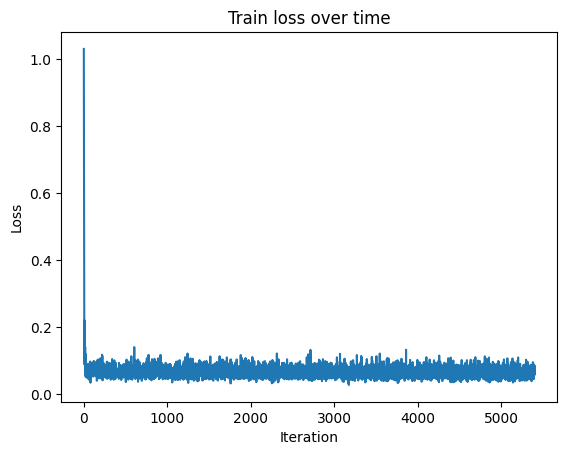

  1%|          | 1/100 [00:14<24:35, 14.90s/it]


Epoch [2/100], Step [5400/3907], Loss: 0.0597


KeyboardInterrupt: 

In [45]:
train(model_AB, optimizer_AB, scheduler_AB, dep_train_dataloader, num_epochs, draw_every=100)

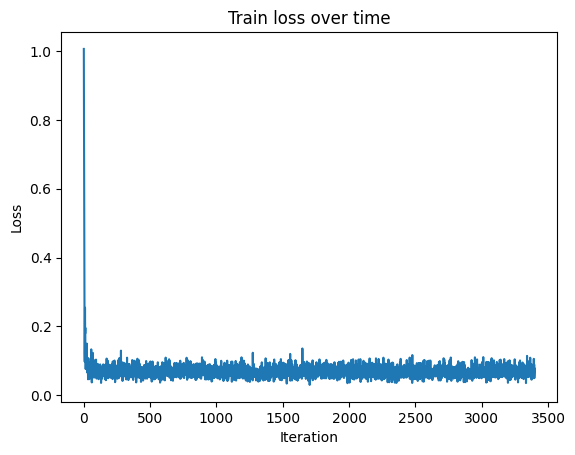

  0%|          | 0/100 [00:08<?, ?it/s]


Epoch [1/100], Step [3400/3907], Loss: 0.0698


KeyboardInterrupt: 

In [46]:
train(model_A_B, optimizer_A_B, scheduler_A_B, indep_train_dataloader, num_epochs, draw_every=100)

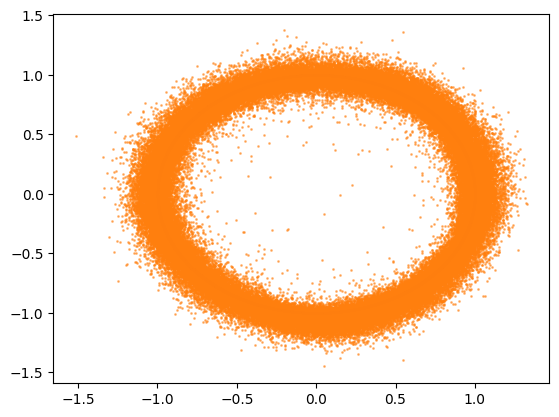

In [47]:
z = torch.randn((100_000, n_dim), device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0)
# p_schedule = 1.0 - torch.linspace(0.0, 0.99, 100, device=device)

with torch.no_grad():
    sampled = model_AB.sample(z, p_schedule)
    
plt.scatter(dep_data[:,0].numpy(), dep_data[:,n_dim-1].numpy(), s=1)
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,n_dim-1].cpu().numpy(), alpha=0.5, s=1)

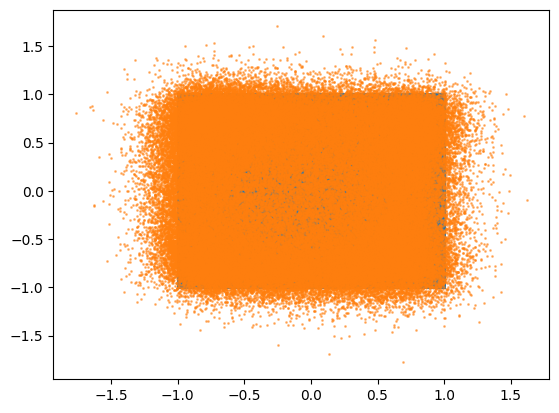

In [48]:
z = torch.randn((100_000, n_dim), device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0)
# p_schedule = 1.0 - torch.linspace(0.0, 0.99, 100, device=device)

with torch.no_grad():
    sampled = model_A_B.sample(z, p_schedule)
    
plt.scatter(indep_data[:,0].numpy(), indep_data[:,n_dim-1].numpy(), s=1)
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,n_dim-1].cpu().numpy(), alpha=0.5, s=1)

In [49]:
def score_func(model, X_t, t):
    p = torch.exp(-t)
    X_t = X_t.to(device)
    p = p.to(device)
    
    denom = torch.sqrt(1 - p ** 2)
    score = -model.denoiser(X_t, p).detach() / denom
    return score

In [ ]:
def estimate_MI(X, num_iters=300_000, T=5):
    I = []
    
    idx = np.random.randint(0, len(X), num_iters)
    ts = torch.rand((num_iters, 1), device=device) * T
    zs = torch.randn(size=(num_iters, 1, X.shape[1])).to(device)
    
    for i in tqdm(range(num_iters)):
        AB = X[idx[i]].unsqueeze(0)
        AB = AB.to(device)
        t = ts[i, :]
        z = zs[i, :, :]

        X_t = torch.exp(-t) * AB + torch.sqrt(1 - torch.exp(-2 * t)) * z
        
        score_AB = score_func(model_AB, X_t, t).cpu()
        score_A_B = score_func(model_A_B, X_t, t).cpu()
        
        I.append(T * ((score_AB - score_A_B) ** 2).sum() / 2)
        
    return np.mean(I)

In [ ]:
# Works better than one above

def estimate_MI_steps(X, dt=0.01, T=5, batch_size=100_000):
    
    t_range = np.arange(2 * dt, T, step=dt)
    average_errors = []
    
    for i in trange(len(t_range) - 1):
        t, dt = torch.tensor(t_range[i]), t_range[i + 1] - t_range[i]
        
        squared_error = 0
        
        idx = np.random.randint(0, len(dep_data), batch_size)
        
        AB = dep_data[idx]
        z = torch.randn(size=(1, dep_data.shape[1]))
        X_t = torch.exp(-t) * AB + torch.sqrt(1 - torch.exp(-2 * t)) * z
        
        t = t * torch.ones((batch_size, 1))
        
        score_AB = score_func(model_AB, X_t, t).cpu()
        score_A_B = score_func(model_A_B, X_t, t).cpu()

        squared_error += torch.square(score_AB - score_A_B).sum()
        
        err = squared_error / batch_size
        average_errors.append(err.item())
        
    return average_errors, np.sum(average_errors) * dt

In [ ]:
estimate_MI(dep_data, num_iters=100_000)

 29%|██▉       | 29112/100000 [00:25<01:02, 1133.75it/s]


KeyboardInterrupt: 

100%|██████████| 498/498 [00:06<00:00, 76.69it/s]

0.6385824469455541


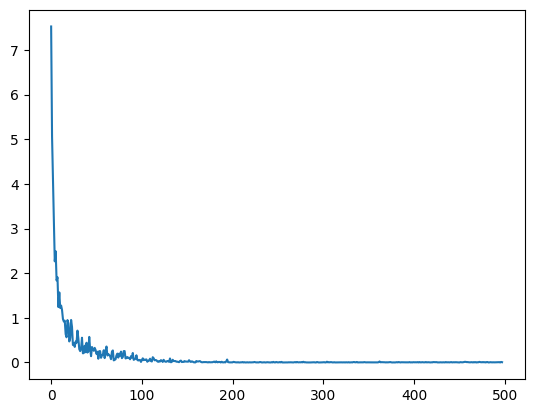

In [ ]:
average_errors, MI = estimate_MI_steps(dep_data, batch_size=100_000, dt=0.01)
print(MI)
plt.plot(average_errors)
plt.show()

In [ ]:
"ground truth:", -1/2 * np.log(1 - 0.7 ** 2)

('ground truth:', 0.33667227663188276)

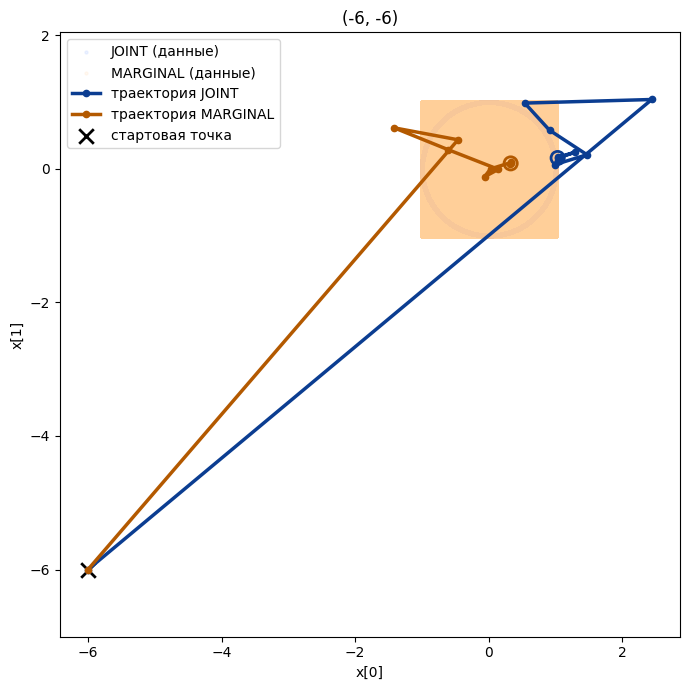

In [50]:
@torch.no_grad()
def build_p_schedule(steps: int, device):
    p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, steps, device=device)**2.0)
    overline_alpha = p_schedule**2
    alpha = overline_alpha[1:] / overline_alpha[:-1]
    beta = 1.0 - alpha
    sigma = torch.sqrt(beta * (1.0 - overline_alpha[:-1]) / (1.0 - overline_alpha[1:]))
    return p_schedule, overline_alpha, alpha, beta, sigma

@torch.no_grad()
def reverse_diffusion_trajectory_from_point_with_noise(
    model: Diffusion,
    start_point: torch.Tensor,      
    eps_seq: torch.Tensor,          
    p_schedule: torch.Tensor,
    overline_alpha: torch.Tensor,
    alpha: torch.Tensor,
    beta: torch.Tensor,
    sigma: torch.Tensor,
    dims=(0, -1),
):
    D = start_point.shape[0]
    i, j = dims
    if j < 0: j = D + j

    x = start_point.unsqueeze(0).to(device)  # (1, D)
    traj = [x[0, [i, j]].detach().cpu().numpy()]

    K = p_schedule.shape[0]
    for step in range(1, K):
        p_t = p_schedule[-step].repeat(1)  
        z_pred = model.denoiser(x, p_t)    
        x = (x - z_pred * beta[-step] / torch.sqrt(1.0 - overline_alpha[-step])) / torch.sqrt(alpha[-step])
        x = x + sigma[-step] * eps_seq[step-1:step, :]  
        traj.append(x[0, [i, j]].detach().cpu().numpy())

    return np.stack(traj)

@torch.no_grad()
def plot_joint_marginal_same_start_shared_noise(
    dep_data: torch.Tensor,        
    indep_data: torch.Tensor,      
    model_joint: Diffusion,
    model_marg: Diffusion,
    dims=(0, -1),
    sampling_steps: int = 100,
    start_xy=(-2.0, -2.0),
    noise_seed: int = 1234,       
):
    D = dep_data.shape[1]
    assert indep_data.shape[1] == D, "Joint и marginal должны иметь одинаковую размерность."
    i, j = dims
    if j < 0: j = D + j

    start = torch.zeros(D, device=device)
    start[i] = float(start_xy[0])
    start[j] = float(start_xy[1])

    p_schedule, overline_alpha, alpha, beta, sigma = build_p_schedule(sampling_steps, device=device)

    g = torch.Generator(device=device)
    g.manual_seed(noise_seed)
    eps_seq = torch.randn((sampling_steps - 1, D), generator=g, device=device)

    traj_joint = reverse_diffusion_trajectory_from_point_with_noise(
        model_joint, start, eps_seq, p_schedule, overline_alpha, alpha, beta, sigma, dims=dims
    )
    traj_marg = reverse_diffusion_trajectory_from_point_with_noise(
        model_marg,  start, eps_seq, p_schedule, overline_alpha, alpha, beta, sigma, dims=dims
    )

    Xj = dep_data.detach().cpu().numpy()
    Xm = indep_data.detach().cpu().numpy()

    plt.figure(figsize=(7, 7))
    plt.scatter(Xj[:, i], Xj[:, j], s=5, alpha=0.12, color="#7aa2ff", label="JOINT (данные)")
    plt.scatter(Xm[:, i], Xm[:, j], s=5, alpha=0.12, color="#ffcf99", label="MARGINAL (данные)")

    plt.plot(traj_joint[:, 0], traj_joint[:, 1], "-o", lw=2.5, ms=4.5, color="#0b3d91", label="траектория JOINT")      
    plt.plot(traj_marg[:,  0], traj_marg[:,  1], "-o", lw=2.5, ms=4.5, color="#b35900", label="траектория MARGINAL")  

    plt.scatter(start_xy[0], start_xy[1], s=110, marker="x", c="black", linewidths=2, label="стартовая точка")
    plt.scatter(traj_joint[-1, 0], traj_joint[-1, 1], s=90, facecolors="none", edgecolors="#0b3d91", linewidths=2)
    plt.scatter(traj_marg[-1, 0],  traj_marg[-1, 1],  s=90, facecolors="none", edgecolors="#b35900", linewidths=2)

    plt.title(f"{start_xy}")
    plt.xlabel(f"x[{i}]"); plt.ylabel(f"x[{j}]")
    plt.axis("equal")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_joint_marginal_same_start_shared_noise(
    dep_data=dep_data,
    indep_data=indep_data,
    model_joint=model_AB,
    model_marg=model_A_B,
    dims=(0, n_dim - 1),
    sampling_steps=10,
    start_xy=(-6, -6),
    noise_seed=41,  
)

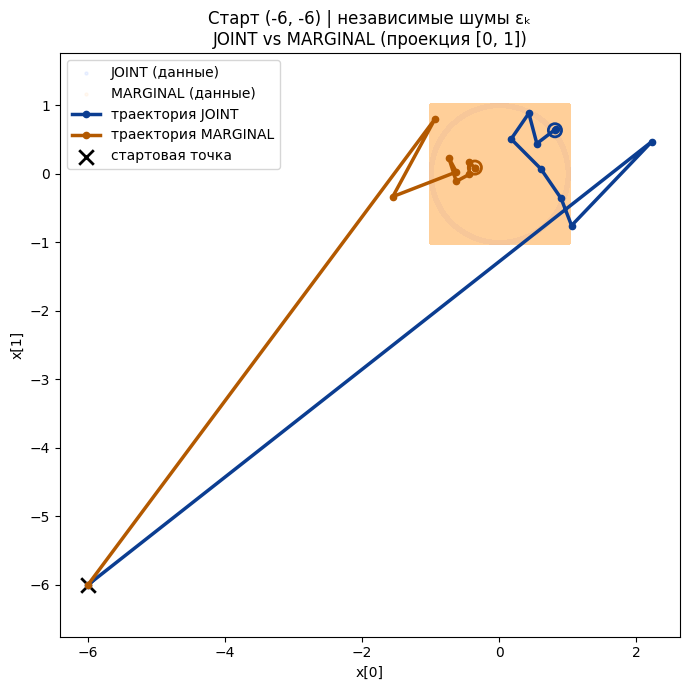

In [51]:
@torch.no_grad()
def plot_joint_marginal_same_start_independent_noise(
    dep_data: torch.Tensor,        
    indep_data: torch.Tensor,     
    model_joint: Diffusion,
    model_marg: Diffusion,
    dims=(0, -1),
    sampling_steps: int = 100,
    start_xy=(-2.0, -2.0),
):
    D = dep_data.shape[1]
    assert indep_data.shape[1] == D, "Joint и marginal должны иметь одинаковую размерность."
    i, j = dims
    if j < 0: j = D + j

    start = torch.zeros(D, device=device)
    start[i] = float(start_xy[0])
    start[j] = float(start_xy[1])

    p_schedule, overline_alpha, alpha, beta, sigma = build_p_schedule(sampling_steps, device=device)

    eps_seq_joint = torch.randn((sampling_steps - 1, D), device=device)
    eps_seq_marg  = torch.randn((sampling_steps - 1, D), device=device)

    traj_joint = reverse_diffusion_trajectory_from_point_with_noise(
        model_joint, start, eps_seq_joint, p_schedule, overline_alpha, alpha, beta, sigma, dims=dims
    )
    traj_marg = reverse_diffusion_trajectory_from_point_with_noise(
        model_marg,  start, eps_seq_marg,  p_schedule, overline_alpha, alpha, beta, sigma, dims=dims
    )

    Xj = dep_data.detach().cpu().numpy()
    Xm = indep_data.detach().cpu().numpy()

    plt.figure(figsize=(7, 7))
    plt.scatter(Xj[:, i], Xj[:, j], s=5, alpha=0.12, color="#7aa2ff", label="JOINT (данные)")
    plt.scatter(Xm[:, i], Xm[:, j], s=5, alpha=0.12, color="#ffcf99", label="MARGINAL (данные)")

    plt.plot(traj_joint[:, 0], traj_joint[:, 1], "-o", lw=2.5, ms=4.5, color="#0b3d91", label="траектория JOINT")
    plt.plot(traj_marg[:,  0], traj_marg[:,  1], "-o", lw=2.5, ms=4.5, color="#b35900", label="траектория MARGINAL")

    plt.scatter(start_xy[0], start_xy[1], s=110, marker="x", c="black", linewidths=2, label="стартовая точка")
    plt.scatter(traj_joint[-1, 0], traj_joint[-1, 1], s=90, facecolors="none", edgecolors="#0b3d91", linewidths=2)
    plt.scatter(traj_marg[-1, 0],  traj_marg[-1, 1],  s=90, facecolors="none", edgecolors="#b35900", linewidths=2)

    plt.title(f"Старт {start_xy} | независимые шумы εₖ\nJOINT vs MARGINAL (проекция [{i}, {j}])")
    plt.xlabel(f"x[{i}]"); plt.ylabel(f"x[{j}]")
    plt.axis("equal")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_joint_marginal_same_start_independent_noise(
    dep_data=dep_data,
    indep_data=indep_data,
    model_joint=model_AB,
    model_marg=model_A_B,
    dims=(0, n_dim - 1),
    sampling_steps=10,
    start_xy=(-6, -6)
)


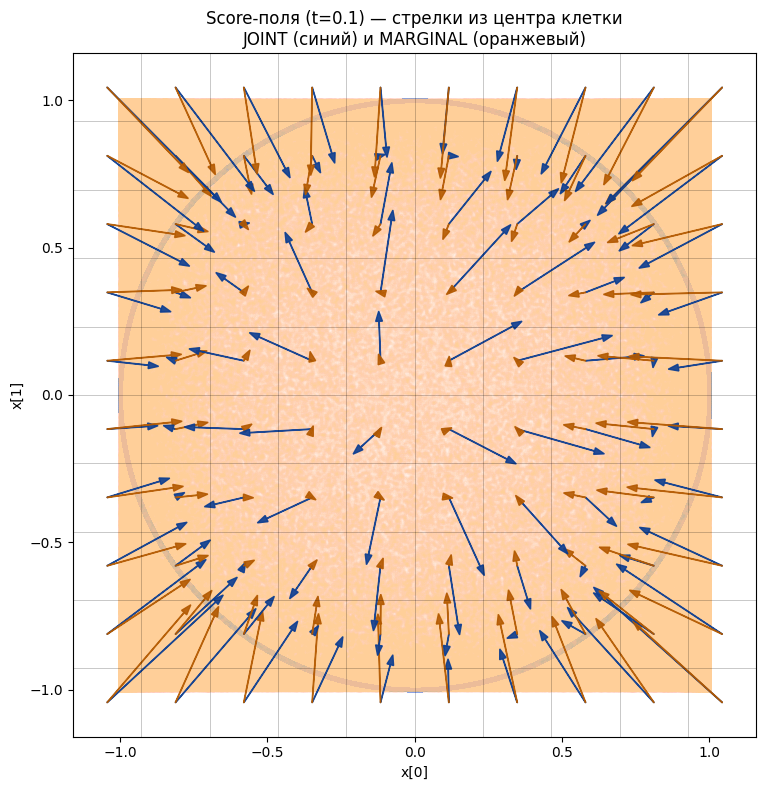

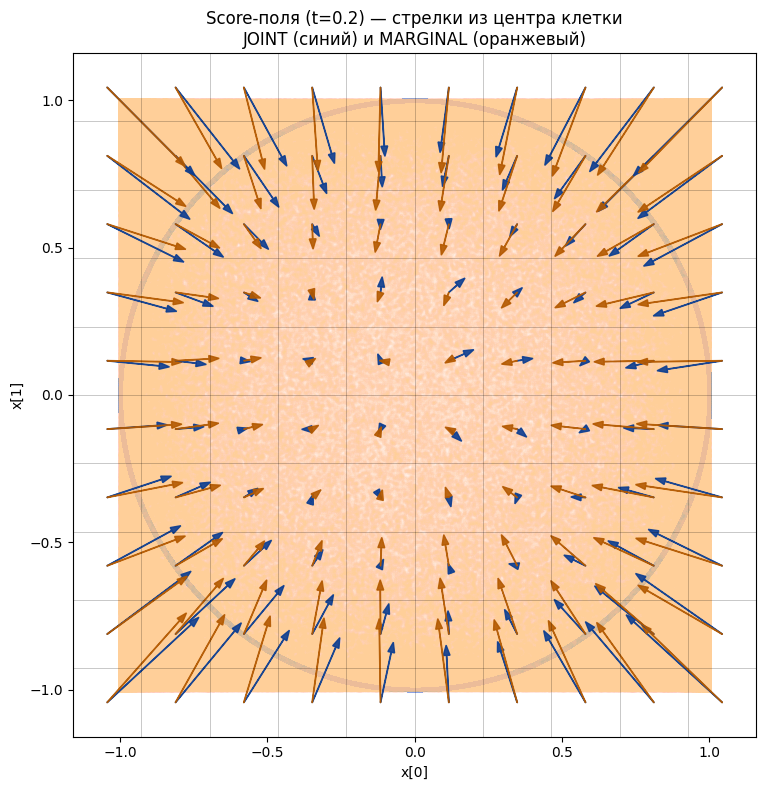

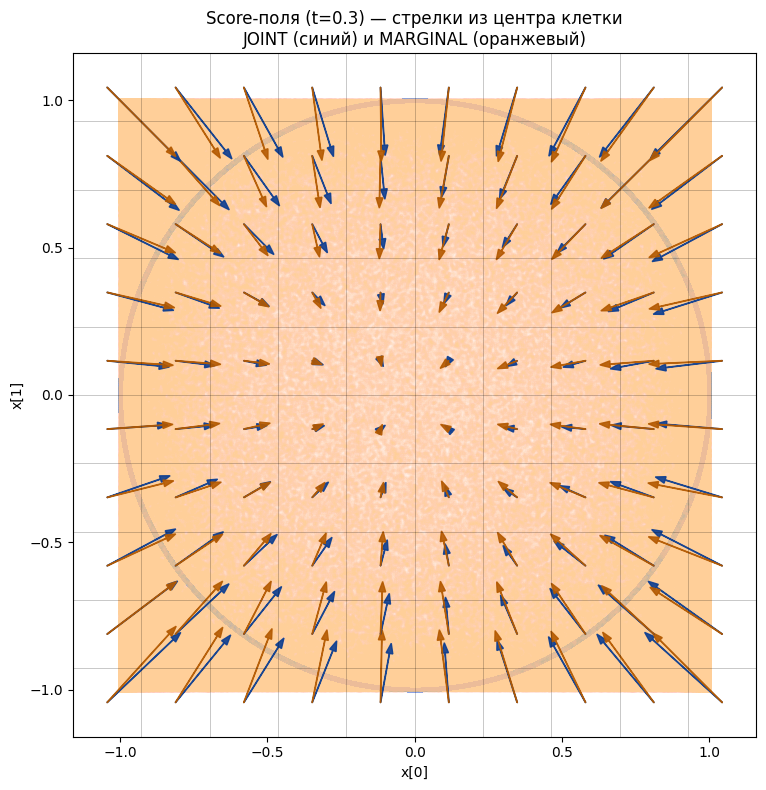

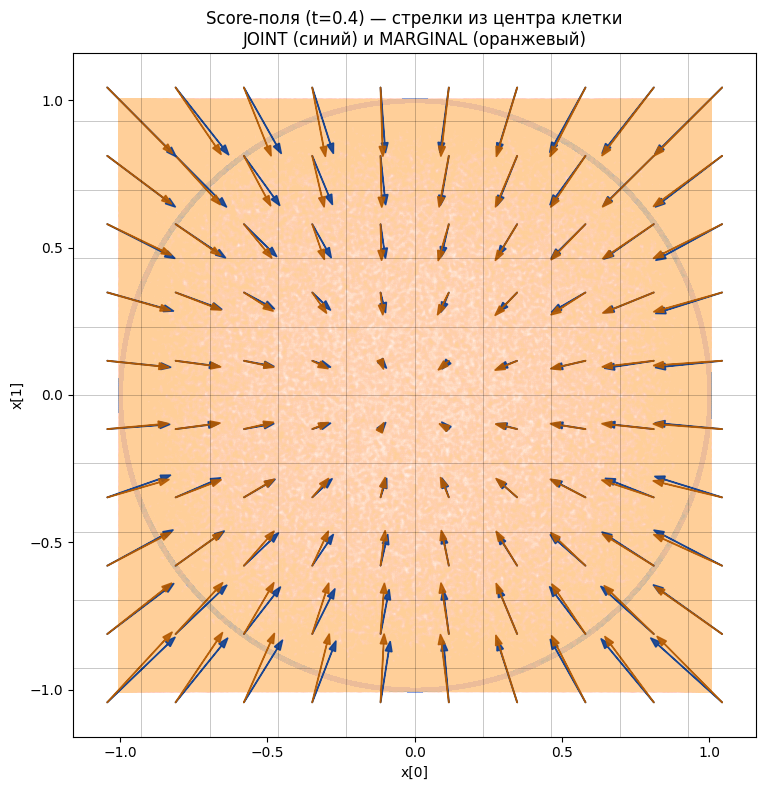

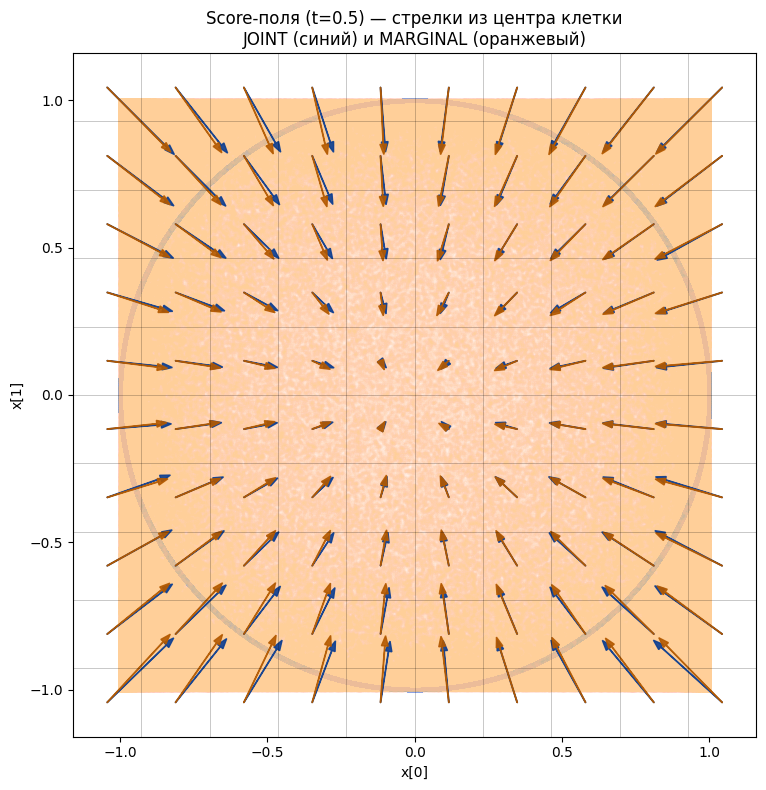

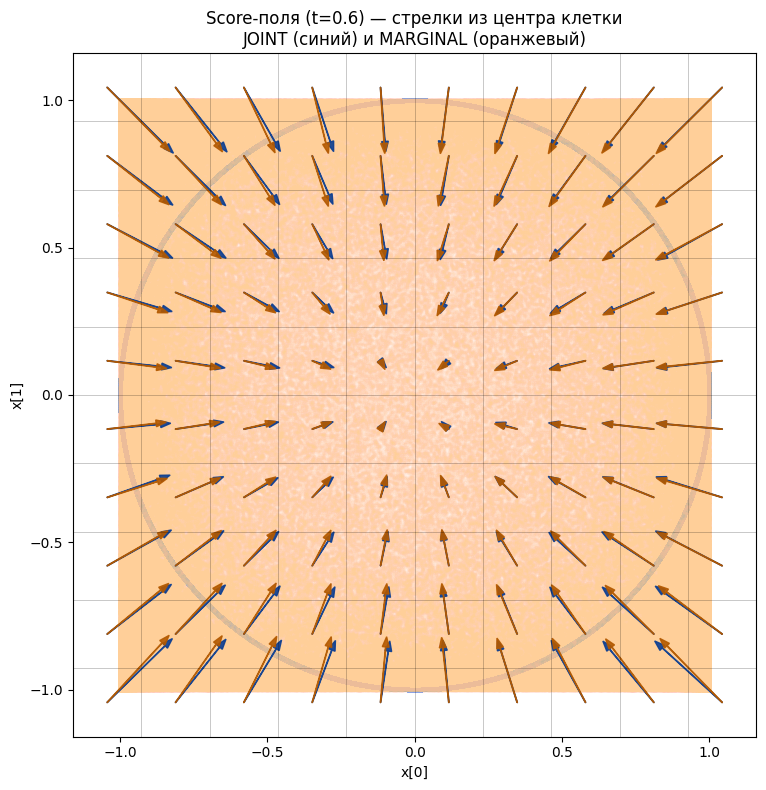

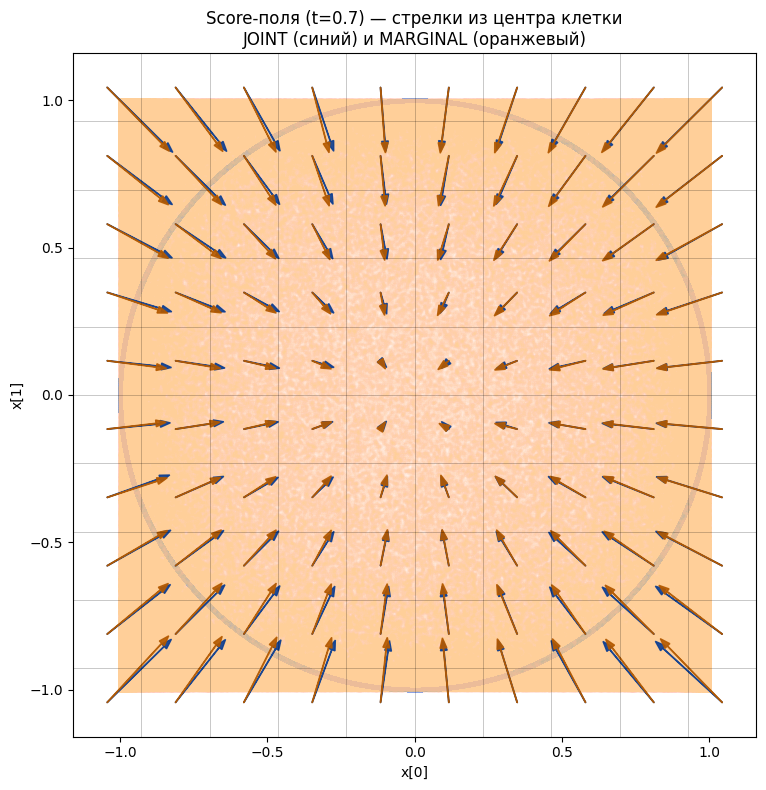

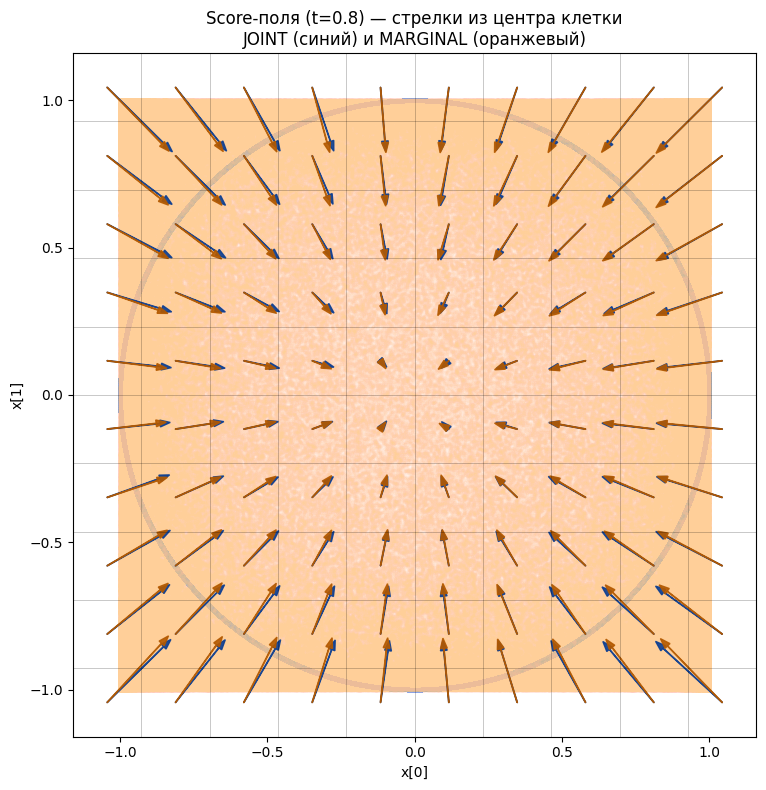

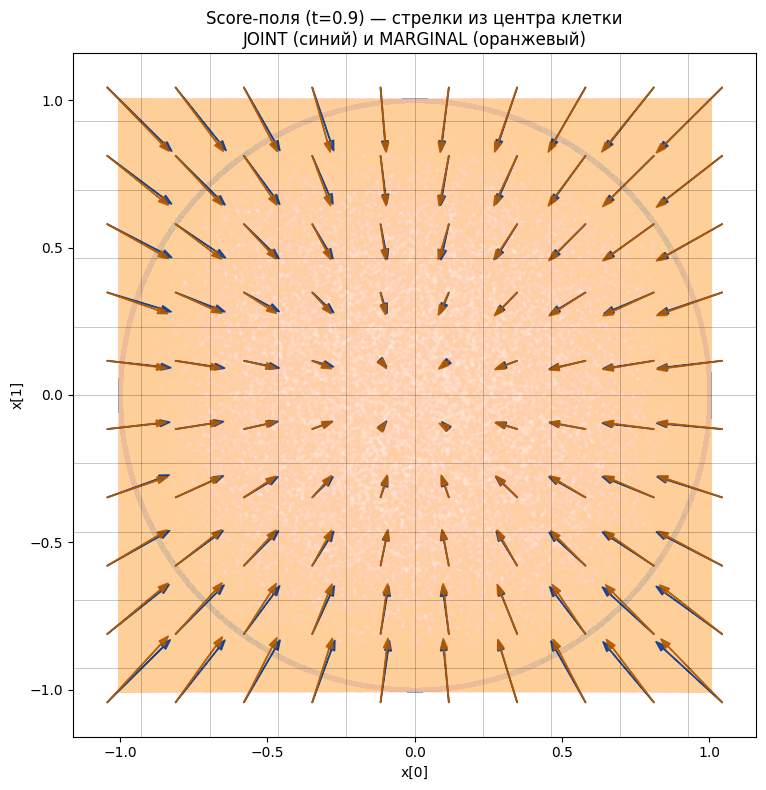

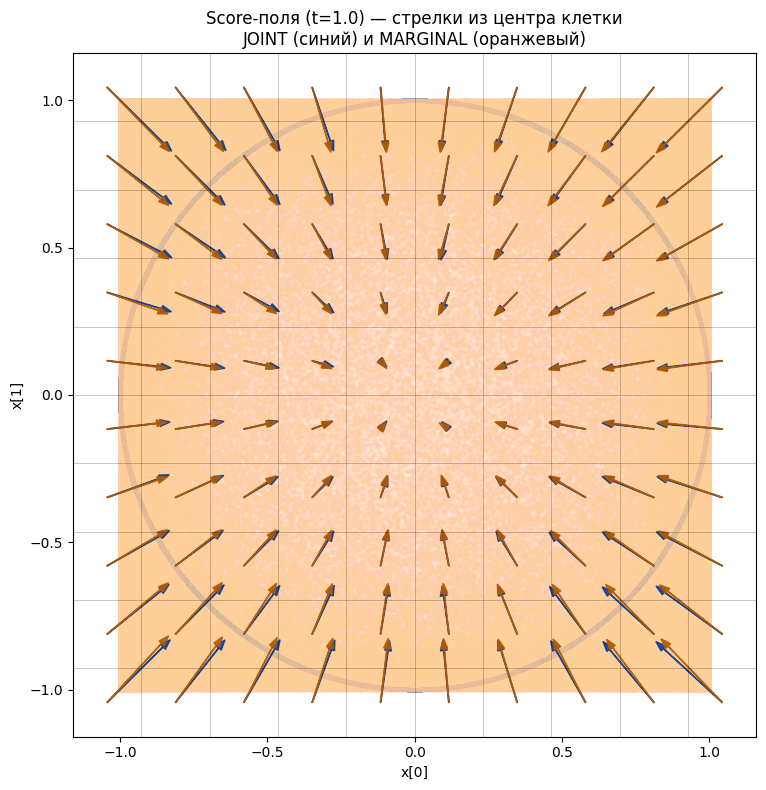

In [59]:
@torch.no_grad()
def plot_score_vector_fields_two_from_one_scaled(
    dep_data: torch.Tensor,
    indep_data: torch.Tensor,
    model_joint: Diffusion,
    model_marg: Diffusion,
    dims=(0, -1),
    n_cells: int = 22,
    margin_frac: float = 0.08,
    t_value: float = 1.0,
    grid_alpha: float = 0.25,
    arrow_scale: float = 0.4,
):

    D = dep_data.shape[1]
    assert indep_data.shape[1] == D

    i, j = dims
    if j < 0: j = D + j

    Xj = dep_data.detach().cpu().numpy()
    Xm = indep_data.detach().cpu().numpy()
    all_x = np.concatenate([Xj[:, i], Xm[:, i]])
    all_y = np.concatenate([Xj[:, j], Xm[:, j]])

    x_pad = (all_x.max() - all_x.min()) * margin_frac
    y_pad = (all_y.max() - all_y.min()) * margin_frac
    xmin, xmax = all_x.min() - x_pad, all_x.max() + x_pad
    ymin, ymax = all_y.min() - y_pad, all_y.max() + y_pad

    xs = np.linspace(xmin, xmax, n_cells + 1)
    ys = np.linspace(ymin, ymax, n_cells + 1)
    cx = (xs[:-1] + xs[1:]) / 2.0
    cy = (ys[:-1] + ys[1:]) / 2.0
    GX, GY = np.meshgrid(cx, cy)
    centers_2d = np.c_[GX.ravel(), GY.ravel()]

    cell_w = (xmax - xmin) / n_cells
    cell_h = (ymax - ymin) / n_cells
    cell_size = min(cell_w, cell_h)

    centers_full = torch.zeros((centers_2d.shape[0], D), device=device)
    centers_full[:, i] = torch.tensor(centers_2d[:, 0], device=device)
    centers_full[:, j] = torch.tensor(centers_2d[:, 1], device=device)

    t_batch = torch.full((centers_full.shape[0], 1), float(t_value), device=device)
    S_joint_full = score_func(model_joint, centers_full, t_batch)
    S_marg_full  = score_func(model_marg,  centers_full, t_batch)

    S_joint = S_joint_full[:, [i, j]].cpu().numpy()
    S_marg  = S_marg_full[:,  [i, j]].cpu().numpy()

    # относительное масштабирование стрелок
    norms_all = np.concatenate([np.linalg.norm(S_joint, axis=1), np.linalg.norm(S_marg, axis=1)])
    median_norm = np.median(norms_all[norms_all > 0]) if np.any(norms_all > 0) else 1.0
    scale_factor = (cell_size * arrow_scale) / median_norm  

    S_joint_scaled = S_joint * scale_factor
    S_marg_scaled  = S_marg  * scale_factor

    fig, ax = plt.subplots(figsize=(8, 8))
    # сетка
    for x in xs:
        ax.plot([x, x], [ymin, ymax], color='k', alpha=grid_alpha, lw=0.6)
    for y in ys:
        ax.plot([xmin, xmax], [y, y], color='k', alpha=grid_alpha, lw=0.6)

    # фоновое распределение
    ax.scatter(Xj[:, i], Xj[:, j], s=3, alpha=0.05, color="#7aa2ff")
    ax.scatter(Xm[:, i], Xm[:, j], s=3, alpha=0.05, color="#ffcf99")

    # стрелки
    for (x0, y0), (u1, v1), (u2, v2) in zip(centers_2d, S_joint_scaled, S_marg_scaled):
        ax.arrow(x0, y0, u1, v1, color="#0b3d91", alpha=0.9,
                 width=0.0015, head_width=cell_size * 0.1, length_includes_head=True)
        ax.arrow(x0, y0, u2, v2, color="#b35900", alpha=0.9,
                 width=0.0015, head_width=cell_size * 0.1, length_includes_head=True)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel(f"x[{i}]")
    ax.set_ylabel(f"x[{j}]")
    ax.set_title(f"Score-поля (t={t_value}) — стрелки из центра клетки\n"
                 f"JOINT (синий) и MARGINAL (оранжевый)")
    plt.tight_layout()
    plt.show()


for i in range(1, 11):
    plot_score_vector_fields_two_from_one_scaled(
        dep_data=dep_data,          # зависимое распределение (JOINT)
        indep_data=indep_data,      # независимое распределение (MARGINAL)
        model_joint=model_AB,       # обученная модель для joint
        model_marg=model_A_B,       # обученная модель для marginal
        dims=(0, n_dim - 1),        # какие оси отобразить (например x[0] и x[3])
        n_cells=10,                 # плотность сетки (меньше → крупнее стрелки)
        t_value=i/10,                # значение времени (0.3 ближе к данным, 2.0 дальше)
        grid_alpha=0.25,            # прозрачность линий сетки
        arrow_scale=0.8           # размер стрелок относительно клетки (0.3–0.5 хорошо)
    )


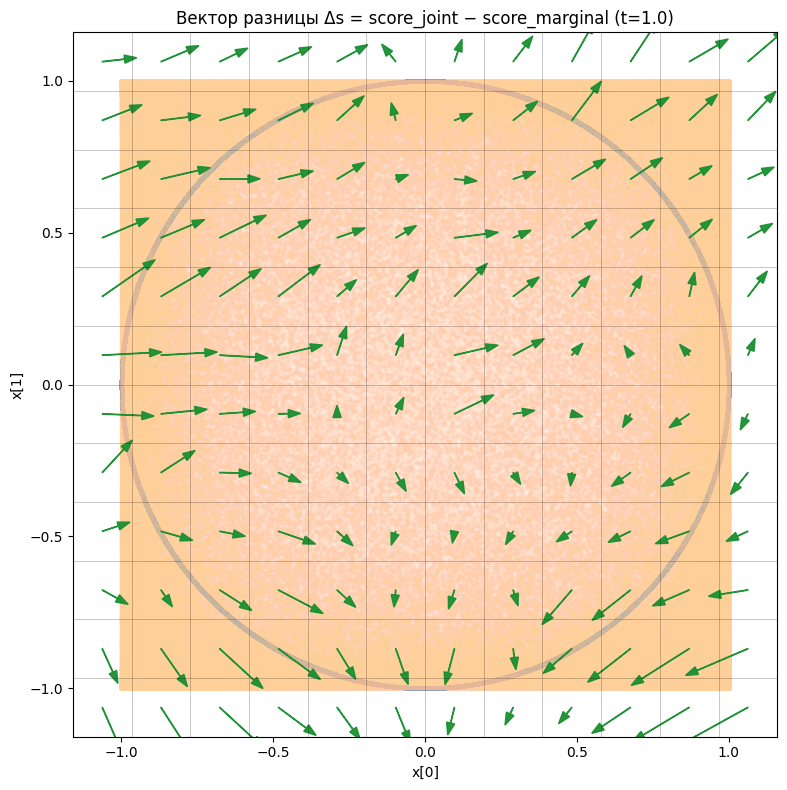

In [57]:
# %% [markdown]
# ## Поле разницы скор-функций (зелёные стрелки): Δs = score_joint - score_marginal

@torch.no_grad()
def plot_score_difference_field(
    dep_data: torch.Tensor,
    indep_data: torch.Tensor,
    model_joint: Diffusion,
    model_marg: Diffusion,
    dims=(0, -1),
    n_cells: int = 22,
    margin_frac: float = 0.08,
    t_value: float = 1.0,
    grid_alpha: float = 0.25,
    origin: str = "corner",        # "corner" | "center" — откуда выводить стрелки
    arrow_scale: float = 0.5,      # базовый размер стрелки относительно клетки
    gain: float = 2.0,             # дополнительное усиление маленьких векторов
    ax=None,                       # можно передать существующие оси для наложения
):
    """
    Рисует зелёные стрелки вектора разницы Δs = s_joint - s_marginal в каждой клетке.
    - Сохраняет относительные длины векторов, но масштабирует их под размер клетки.
    - origin: "corner" — из левого нижнего угла клетки; "center" — из центра клетки.
    - Можно рисовать на переданных осях ax (накладывать поверх другого графика).
    """

    D = dep_data.shape[1]
    assert indep_data.shape[1] == D, "Размерности joint и marginal должны совпадать."

    i, j = dims
    if j < 0: j = D + j

    # --- границы области (по обоим датасетам) ---
    Xj = dep_data.detach().cpu().numpy()
    Xm = indep_data.detach().cpu().numpy()
    all_x = np.concatenate([Xj[:, i], Xm[:, i]])
    all_y = np.concatenate([Xj[:, j], Xm[:, j]])

    x_pad = (all_x.max() - all_x.min()) * margin_frac + 1e-12
    y_pad = (all_y.max() - all_y.min()) * margin_frac + 1e-12
    xmin, xmax = all_x.min() - x_pad, all_x.max() + x_pad
    ymin, ymax = all_y.min() - y_pad, all_y.max() + y_pad

    # --- сетка ---
    xs = np.linspace(xmin, xmax, n_cells + 1)
    ys = np.linspace(ymin, ymax, n_cells + 1)
    if origin == "center":
        cx = (xs[:-1] + xs[1:]) / 2.0
        cy = (ys[:-1] + ys[1:]) / 2.0
        GX, GY = np.meshgrid(cx, cy)
    else:  # "corner" — берём левый нижний угол каждой клетки
        GX, GY = np.meshgrid(xs[:-1], ys[:-1])

    starts_2d = np.c_[GX.ravel(), GY.ravel()]  # точки старта стрелок (M,2)

    # размер клетки
    cell_w = (xmax - xmin) / n_cells
    cell_h = (ymax - ymin) / n_cells
    cell_size = float(min(cell_w, cell_h))

    # --- батч точек (полная размерность), остальные координаты = 0 ---
    starts_full = torch.zeros((starts_2d.shape[0], D), device=device)
    starts_full[:, i] = torch.tensor(starts_2d[:, 0], device=device, dtype=torch.float32)
    starts_full[:, j] = torch.tensor(starts_2d[:, 1], device=device, dtype=torch.float32)

    # время одно и то же для всех точек
    t_batch = torch.full((starts_full.shape[0], 1), float(t_value), device=device)

    # --- считаем скор и разницу ---
    S_joint_full = score_func(model_joint, starts_full, t_batch)
    S_marg_full  = score_func(model_marg,  starts_full, t_batch)

    S_joint = S_joint_full[:, [i, j]].detach().cpu().numpy()
    S_marg  = S_marg_full[:,  [i, j]].detach().cpu().numpy()
    S_diff  = S_joint - S_marg  # Δs

    # --- масштабирование: сохраняем относительные величины, но делаем заметным ---
    norms = np.linalg.norm(S_diff, axis=1)
    # ориентируемся на медиану ненулевых длин (устойчивее к выбросам), усиливаем gain'ом
    nz = norms > 0
    base = np.median(norms[nz]) if np.any(nz) else 1.0
    scale_factor = (cell_size * arrow_scale * gain) / base if base > 0 else 1.0
    S_diff_scaled = S_diff * scale_factor

    # --- рисование ---
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        created_fig = True
        # фоновые данные очень бледно (можно убрать, если накладываешь на другой график)
        ax.scatter(Xj[:, i], Xj[:, j], s=3, alpha=0.04, color="#7aa2ff")
        ax.scatter(Xm[:, i], Xm[:, j], s=3, alpha=0.04, color="#ffcf99")
        # явный mesh
        for x in xs:
            ax.plot([x, x], [ymin, ymax], color='k', alpha=grid_alpha, lw=0.6)
        for y in ys:
            ax.plot([xmin, xmax], [y, y], color='k', alpha=grid_alpha, lw=0.6)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel(f"x[{i}]"); ax.set_ylabel(f"x[{j}]")
        ax.set_title(f"Вектор разницы Δs = score_joint − score_marginal (t={t_value})")

    # зелёные стрелки из выбранных точек
    for (x0, y0), (u, v) in zip(starts_2d, S_diff_scaled):
        ax.arrow(x0, y0, u, v,
                 color="#1a8f31", alpha=0.95,
                 width=0.0015, head_width=cell_size * 0.14,
                 length_includes_head=True)

    if created_fig:
        plt.tight_layout()
        plt.show()


plot_score_difference_field(
    dep_data=dep_data,
    indep_data=indep_data,
    model_joint=model_AB,
    model_marg=model_A_B,
    dims=(0, n_dim - 1),
    n_cells=12,
    t_value=1.0,
    origin="center",     # или "center"
    arrow_scale=0.2,
    gain=3.0             # усиление маленьких разниц — сделай больше/меньше по вкусу
)

